## CASE STUDY 001

Aplicando SOM para análise do acumulado de flashes horário em cada estado brasileiro

In [494]:
import sys; sys.path.insert(0, "/home/adriano/sthunder")
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sthunder import constants as const
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from mpl_toolkits.axes_grid1 import make_axes_locatable

from minisom import MiniSom

In [142]:
flashes_df = pd.read_csv("/glm/city_state.csv")
flashes_df.head()

,city,uf,total,datetime,coords
0,Abel Figueiredo,PA,0,2020-01-01 00:00:00,POINT(-48.5 -5)
1,Abel Figueiredo,PA,0,2020-01-01 01:00:00,POINT(-48.5 -5)
2,Abel Figueiredo,PA,0,2020-01-01 02:00:00,POINT(-48.5 -5)
3,Abel Figueiredo,PA,0,2020-01-01 03:00:00,POINT(-48.5 -5)
4,Abel Figueiredo,PA,0,2020-01-01 04:00:00,POINT(-48.5 -5)


In [143]:
flashes_df = flashes_df.groupby(
    ['uf', 'datetime']
).aggregate({'total': 'sum'}).reset_index()
flashes_df.head()

,uf,datetime,total
0,AC,2020-01-01 00:00:00,263
1,AC,2020-01-01 01:00:00,42
2,AC,2020-01-01 02:00:00,0
3,AC,2020-01-01 03:00:00,0
4,AC,2020-01-01 04:00:00,0


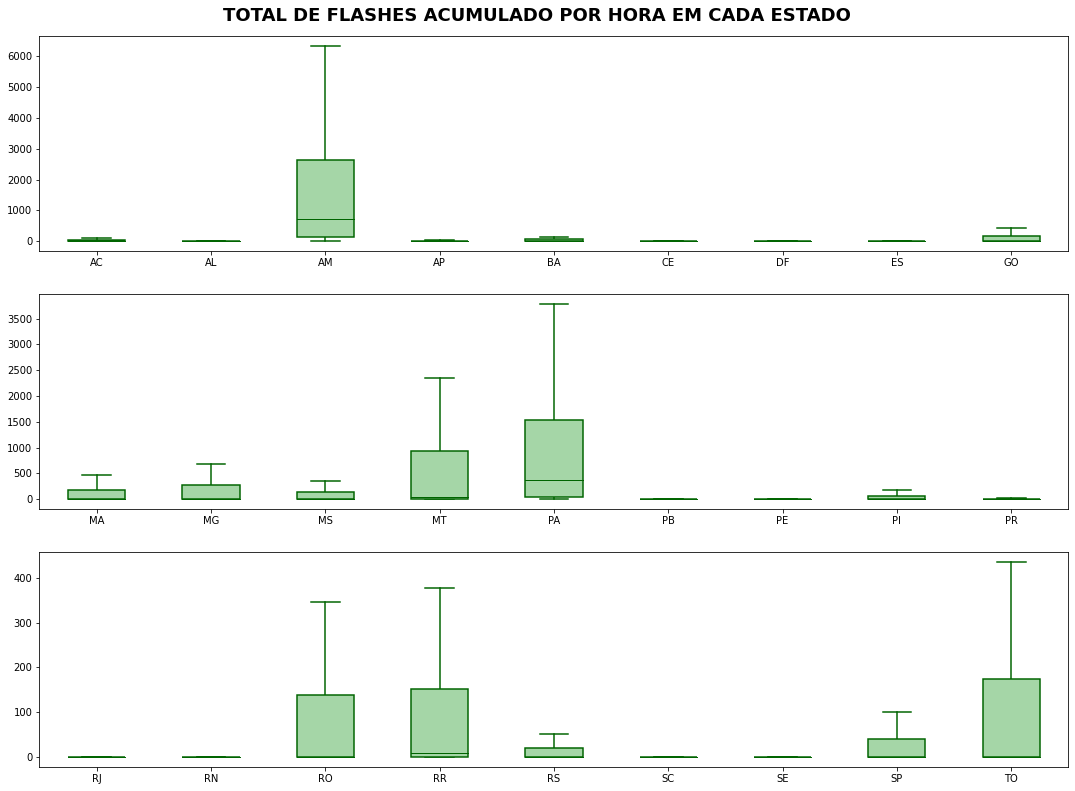

In [144]:
ufs = sorted(areas.keys())

dpi = 100
width = np.round(1366 * 135 / 100)
height = 768*1.75
    
fig, ax = plt.subplots(3, 1, figsize=(width/dpi, height/dpi), facecolor = 'white')
fig.suptitle(f"TOTAL DE FLASHES ACUMULADO POR HORA EM CADA ESTADO", fontsize=18, fontweight='bold', y=0.91)
for i in range(0, 27, 9):
    data = []
    for uf in ufs[i:i+9]:
        data.append(flashes_df.query(f"uf == '{uf}'").total.values)
    
    bp = ax[i//9].boxplot(data, showfliers=False, patch_artist=True)
    plt.setp(bp['means'], color='darkgreen')
    plt.setp(bp['medians'], color='darkgreen')
    plt.setp(bp['caps'], color='darkgreen', linewidth=1.5)
    plt.setp(bp['whiskers'], color='darkgreen', linewidth=1.5)
    
    for box in bp['boxes']:
        box.set(facecolor='#a5d6a7', edgecolor='darkgreen', linewidth=1.5)
    
    ax[i//9].set_xticklabels(ufs[i:i+9])
    
plt.savefig(f"../flashamount_uf_hourly.png", 
                transparent=False, bbox_inches='tight', pad_inches=0.1)

In [145]:
area_df = pd.read_csv(
    "/glm/city_state_area.csv"
)[['uf', 'area_state']]
areas = {row['uf']: row['area_state'] for _, row in area_df.iterrows()}
area_df.head()

,uf,area_state
0,GO,370.628145
1,MG,656.245889
2,GO,370.628145
3,MG,656.245889
4,PA,1265.673821


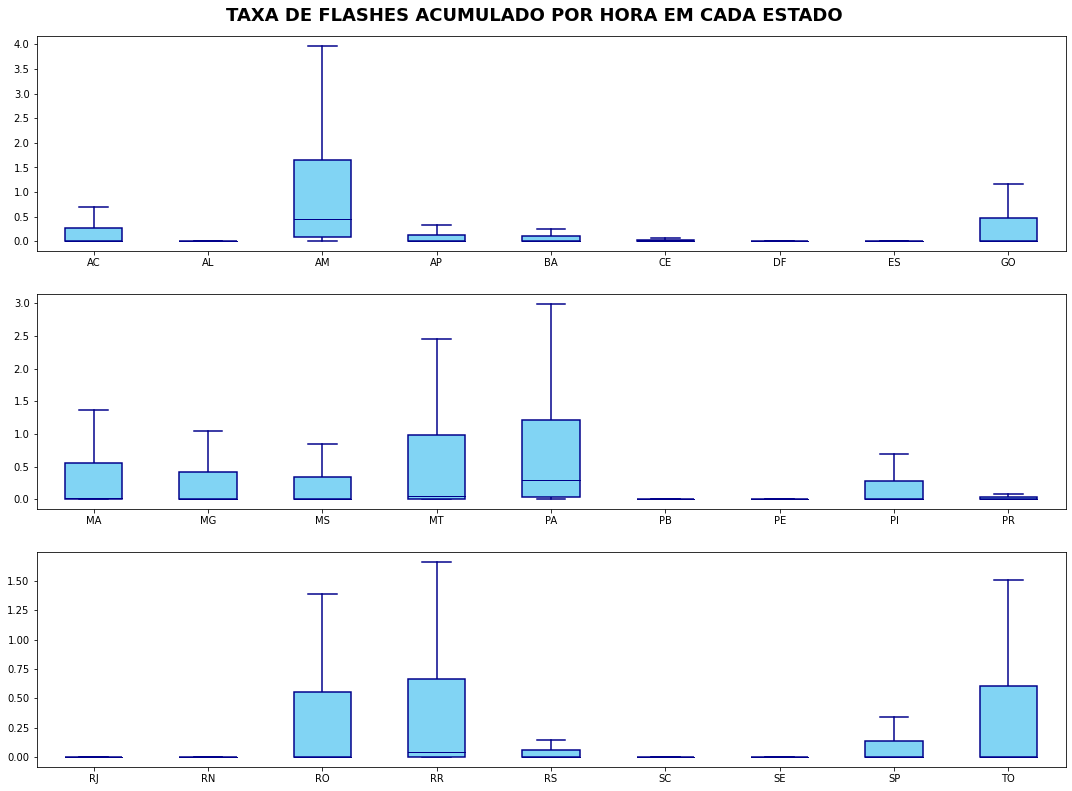

In [146]:
ufs = sorted(areas.keys())

dpi = 100
width = np.round(1366 * 135 / 100)
height = 768*1.75
    
fig, ax = plt.subplots(3, 1, figsize=(width/dpi, height/dpi), facecolor = 'white')
fig.suptitle(f"TAXA DE FLASHES ACUMULADO POR HORA EM CADA ESTADO", fontsize=18, fontweight='bold', y=0.91)
for i in range(0, 27, 9):
    data = []
    for uf in ufs[i:i+9]:
        data.append(flashes_df.query(f"uf == '{uf}'").total.values/areas[uf])
    
    bp = ax[i//9].boxplot(data, showfliers=False, patch_artist=True)
    plt.setp(bp['means'], color='darkblue')
    plt.setp(bp['medians'], color='darkblue')
    plt.setp(bp['caps'], color='darkblue', linewidth=1.5)
    plt.setp(bp['whiskers'], color='darkblue', linewidth=1.5)
    
    for box in bp['boxes']:
        box.set(facecolor='#81D4F4', edgecolor='darkblue', linewidth=1.5)
    
    ax[i//9].set_xticklabels(ufs[i:i+9])
    
plt.savefig(f"../flashrate_uf_hourly.png", 
                transparent=False, bbox_inches='tight', pad_inches=0.1)

In [149]:
pivot_table = flashes_df.pivot(
     columns='uf', index='datetime', values='total'
).reset_index()

pivot_table['datetime'] = pd.to_datetime(pivot_table['datetime'])
pivot_table = pivot_table.set_index('datetime')
pivot_table.head()

uf,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,263,0,88,0,140,62,0,0,1969,79,...,173,0,8,27,0,210,92,48,148,132
2020-01-01 01:00:00,42,0,116,0,57,114,0,0,735,30,...,66,0,20,38,0,31,0,80,321,19
2020-01-01 02:00:00,0,0,119,0,294,77,0,0,161,3,...,13,0,31,47,0,8,5,13,58,2
2020-01-01 03:00:00,0,1,94,0,15,61,1,0,188,1,...,17,0,22,32,0,1,80,0,66,0
2020-01-01 04:00:00,0,0,85,0,218,42,25,0,168,0,...,0,0,1,38,0,0,37,0,139,9


In [567]:
data = pivot_table.values.T
nrow, ncol = 13, 13

SOM = MiniSom(x=nrow, y=ncol, input_len=data.shape[1], sigma=2,learning_rate=0.5, neighborhood_function='gaussian',
             topology='rectangular', activation_distance='euclidean', random_seed=42)
SOM.random_weights_init(data=data)
SOM.train_random(data=data, num_iteration=500)

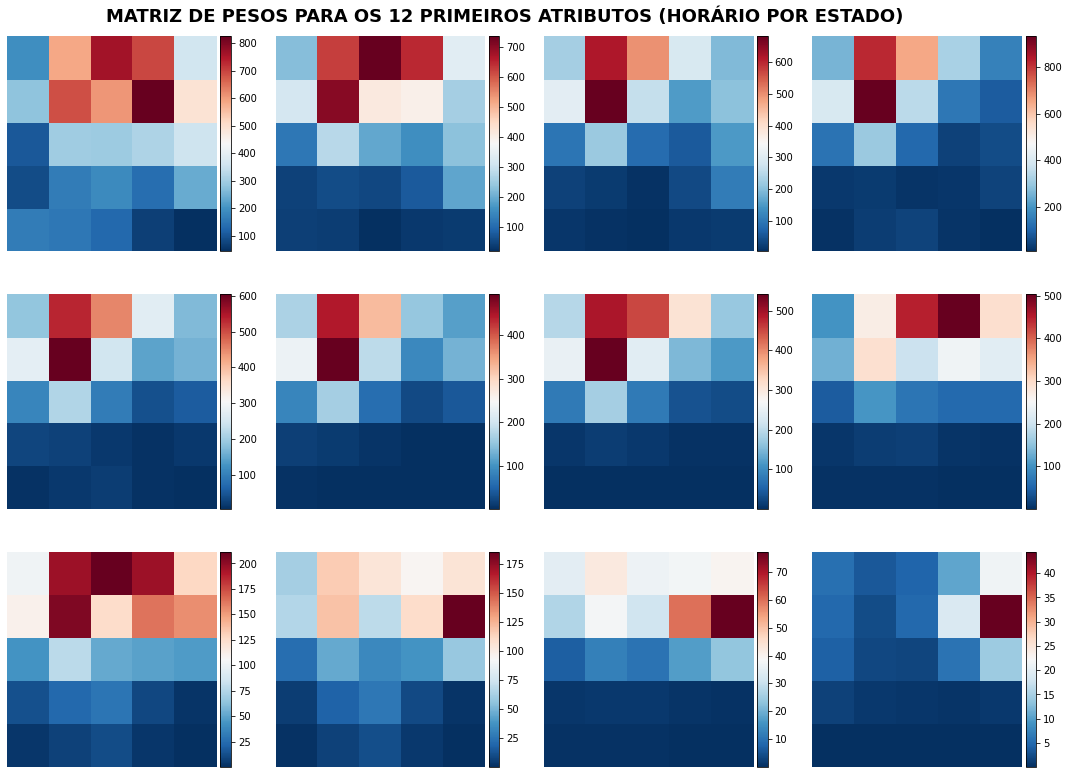

In [568]:
dpi = 100
width = np.round(1366 * 135 / 100)
height = 768*1.75
    
fig, ax = plt.subplots(3, 4, figsize=(width/dpi, height/dpi), facecolor = 'white')
fig.suptitle(f"MATRIZ DE PESOS PARA OS 12 PRIMEIROS ATRIBUTOS (HORÁRIO POR ESTADO)", 
             fontsize=18, fontweight='bold', y=0.91)

for i in range(12):
    row = i//4
    col = i%4
    
    divider = make_axes_locatable(ax[row][col])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    img = ax[row][col].pcolor(SOM._weights[:, :, i], cmap='RdBu_r')
    fig.colorbar(img, cax=cax, orientation='vertical')
    ax[row][col].axis('off')
    
plt.savefig(f"../weights_uf_hourly_nn.png", 
                transparent=False, bbox_inches='tight', pad_inches=0.1)

In [196]:
w[w>20000]

array([22275.38030318, 37770.94366665, 45855.36967436, 51764.39464225,
       39557.90545914, 30777.27935698, 20764.4109476 , 23644.08173644,
       26155.65814898, 23110.07671601, 24570.91829069, 23667.81468873,
       20796.71063344, 22178.99535324, 23337.36957968, 24104.28061053,
       25615.62210985, 28542.8946278 , 21173.1359758 , 24475.27578636,
       24207.90948412, 20151.31825884, 27845.94134548, 26262.78758071,
       23212.6405538 , 22759.66472355, 20115.02718375, 26948.41198944,
       33337.83010178, 34992.42993947, 42059.0135556 , 33617.57070677,
       22252.50785264, 24040.18634535, 29011.19501584, 26457.36518534,
       24510.42400964, 25770.48444253, 23461.37213546, 21290.01893939,
       29519.59608379, 32081.57431808, 34780.49815413, 28980.36033362,
       26321.45085913, 20051.7169331 , 21643.2747663 , 26236.51417938,
       26965.63714156, 22097.68290051, 20015.16566355])

(0.0, 13.0)

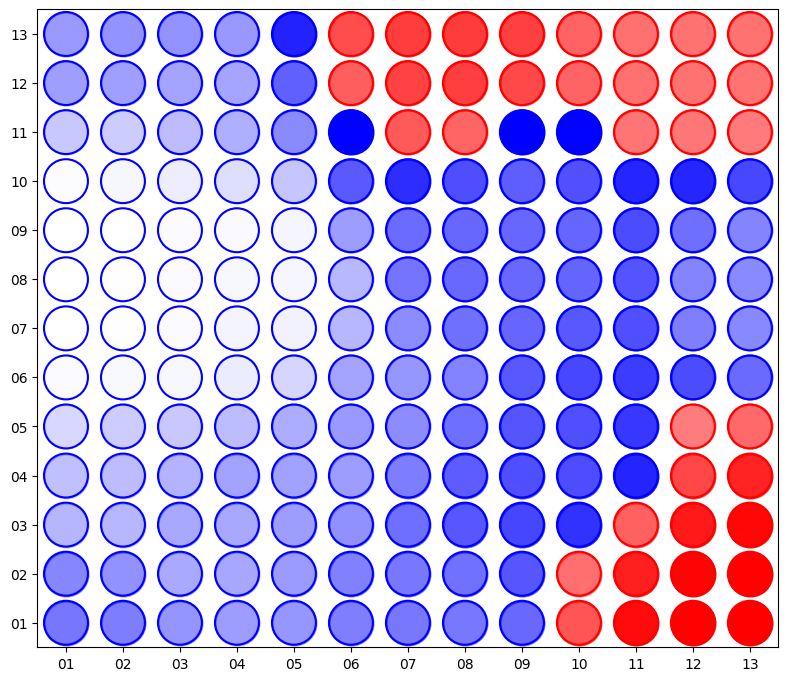

In [239]:
color_map = np.full((*SOM._weights.shape[:-1],), 'white')
alpha_map = np.full((*SOM._weights.shape[:-1],), 0.)

P90 = np.percentile(data.ravel(), 90)
THR = 0.25
markersize = 1000
linewidth = 1.5

for i in np.arange(SOM._weights.shape[0]):
    for j in np.arange(SOM._weights.shape[1]):
        w = SOM._weights[i, j, :]
        act = w[w>=P90].shape[0]
        ina = w[w<P90].shape[0]
        
        if act/(act+ina) >= THR:
            color_map[i][j] = 'red'
            alpha_map[i][j] = act/(act+ina)
        else:
            color_map[i][j] = 'blue'
            alpha_map[i][j] = act/(act+ina)
            
xb, yb = np.where(color_map == 'blue')
xr, yr = np.where(color_map == 'red')

alpha_map[xb, yb] = alpha_map[xb, yb]/alpha_map[xb, yb].max()
alpha_map[xr, yr] = alpha_map[xr, yr]/alpha_map[xr, yr].max()


dpi = 100
width = np.round(1366 * 70 / 100)
height = 768*1.1
facecolor = 'white'

fig, ax = plt.subplots(figsize=(width/dpi, height/dpi), 
                       dpi=dpi, facecolor=facecolor)

for i in range(color_map.shape[0]):
    for j in range(color_map.shape[1]):
        ax.scatter([i+.5], [j+.5], color=color_map[i][j], marker='o', s=1000, alpha=alpha_map[i][j], 
                lw=1.5, ec=color_map[i][j], zorder=1)
        ax.scatter([i+.5], [j+.5], color='none', marker='o', s=1000,
                lw=1.5, ec=color_map[i][j], zorder=2)
       
ax.set_xticks(np.arange(13)+0.5)
ax.set_xticklabels([str(v).zfill(2) for v in np.arange(13)+1])
ax.set_yticks(np.arange(13)+0.5)
ax.set_yticklabels([str(v).zfill(2) for v in np.arange(13)+1])
ax.set_xlim([0, color_map.shape[0]])
ax.set_ylim([0, color_map.shape[1]])

15.0
51.0
138.0
327.0
765.0
916.0
1098.0
1326.0
1620.9799999999814
2003.0
3337.9899999999907
7265.659999999974


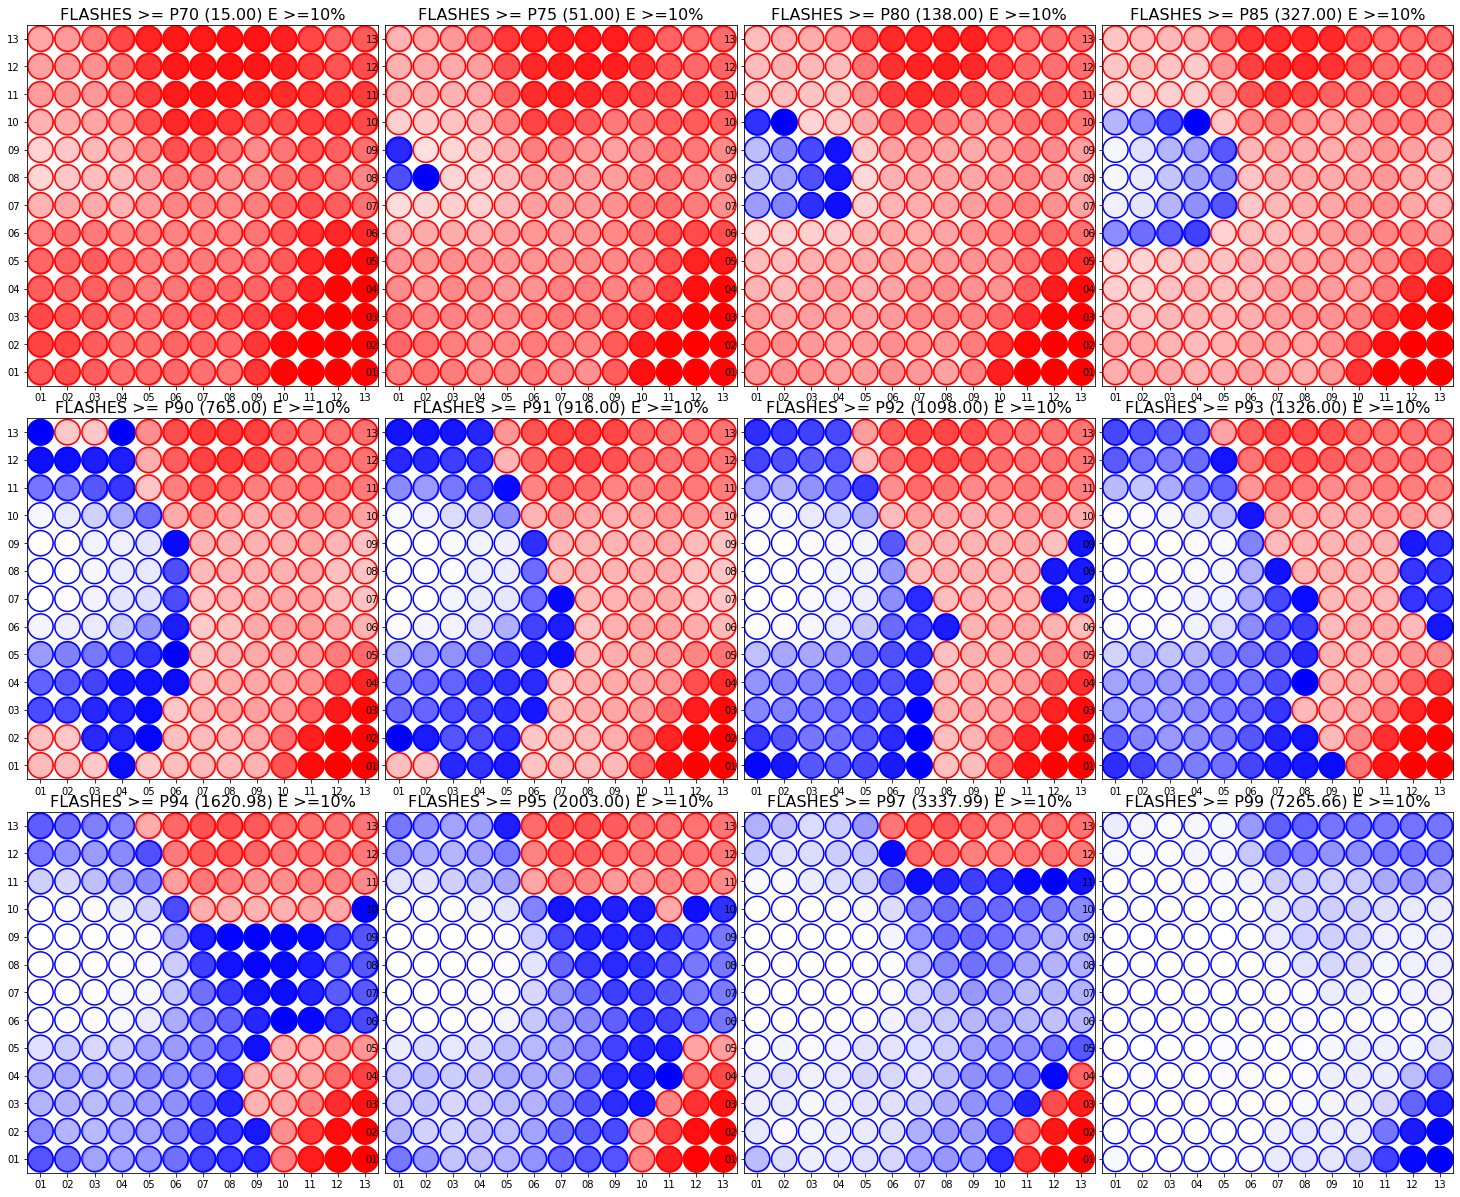

In [537]:
dpi = 100
width = np.round(1366 * 145 / 100)
height = 768*2.75
    
fig, ax = plt.subplots(3, 4, figsize=(width/dpi, height/dpi), facecolor = 'white')

PS = [
    70, 75, 80, 85, 90, 91, 92, 93, 94, 95, 97, 99
]
PCT = [np.percentile(data.ravel(), pn) for pn in PS]

titles = [f"FLASHES >= P{pn} ({PCT[i]:.2f}) E >=10%" for i, pn in enumerate(PS)]

for x in range(12):
    row = x//4
    col = x%4
    
    color_map = np.full((*SOM._weights.shape[:-1],), 'white')
    alpha_map = np.full((*SOM._weights.shape[:-1],), 0.)
    
    P90 = PCT[x]
    print(P90)
    THR = 0.10
    markersize = 1000
    linewidth = 1.5

    for i in np.arange(SOM._weights.shape[0]):
        for j in np.arange(SOM._weights.shape[1]):
            w = SOM._weights[i, j, :]
            act = w[w>=P90].shape[0]
            ina = w[w<P90].shape[0]

            if act/(act+ina) >= THR:
                color_map[i][j] = 'red'
                alpha_map[i][j] = act/(act+ina)
            else:
                color_map[i][j] = 'blue'
                alpha_map[i][j] = act/(act+ina)

    xb, yb = np.where(color_map == 'blue')
    xr, yr = np.where(color_map == 'red')
    
    if len(xb) > 0:
        alpha_map[xb, yb] = alpha_map[xb, yb]/alpha_map[xb, yb].max()
    if len(xr) > 0:
        alpha_map[xr, yr] = alpha_map[xr, yr]/alpha_map[xr, yr].max()


    dpi = 100
    width = np.round(1366 * 70 / 100)
    height = 768*1.1
    facecolor = 'white'

    for i in range(color_map.shape[0]):
        for j in range(color_map.shape[1]):
            ax[row][col].scatter([i+.5], [j+.5], color=color_map[i][j], marker='o', s=640, alpha=alpha_map[i][j], 
                    lw=1.5, ec=color_map[i][j], zorder=1)
            ax[row][col].scatter([i+.5], [j+.5], color='none', marker='o', s=640,
                    lw=1.5, ec=color_map[i][j], zorder=2)

    ax[row][col].set_xticks(np.arange(13)+0.5)
    ax[row][col].set_xticklabels([str(v).zfill(2) for v in np.arange(13)+1])
    ax[row][col].set_yticks(np.arange(13)+0.5)
    ax[row][col].set_yticklabels([str(v).zfill(2) for v in np.arange(13)+1])
    ax[row][col].set_title(titles[x], fontdict={'size': 16})
#     ax[row][col].axis('off')
    
    ax[row][col].set_xlim([0, color_map.shape[0]])
    ax[row][col].set_ylim([0, color_map.shape[1]])
#     break

plt.subplots_adjust(left=0, bottom=None, right=1, top=None,
                        hspace=0.09, wspace=0.02)

plt.savefig(f"../neurons_percentile_variation.png", 
                transparent=False, bbox_inches='tight', pad_inches=0.1)

In [339]:
color_map = np.full((*SOM._weights.shape[:-1],), 'white')
alpha_map = np.full((*SOM._weights.shape[:-1],), 0.)

P90 = np.percentile(data.ravel(), 90)
THR = 0.10
markersize = 1000
linewidth = 1.5

for i in np.arange(SOM._weights.shape[0]):
    for j in np.arange(SOM._weights.shape[1]):
        w = SOM._weights[i, j, :]
        act = w[w>=P90].shape[0]
        ina = w[w<P90].shape[0]

        if act/(act+ina) >= THR:
            color_map[i][j] = 'red'
            alpha_map[i][j] = act/(act+ina)
        else:
            color_map[i][j] = 'blue'
            alpha_map[i][j] = act/(act+ina)

xb, yb = np.where(color_map == 'blue')
xr, yr = np.where(color_map == 'red')

if len(xb) > 0:
    alpha_map[xb, yb] = alpha_map[xb, yb]/alpha_map[xb, yb].max()
if len(xr) > 0:
    alpha_map[xr, yr] = alpha_map[xr, yr]/alpha_map[xr, yr].max()

In [335]:
ngdf = gpd.read_file(
    const.SHP_BRAZIL_STATES
).set_index('sigla').loc[pivot_table.columns][['geometry']]

ngdf.head()

,geometry
uf,
AC,"POLYGON ((-73.60818 -7.20194, -72.86963 -7.528..."
AL,"POLYGON ((-35.46516 -8.82549, -35.46626 -8.827..."
AM,"POLYGON ((-67.32553 2.03012, -67.32234 2.01741..."
AP,"POLYGON ((-51.18168 4.00889, -51.17900 3.99812..."
BA,"POLYGON ((-39.28820 -8.56290, -39.28229 -8.567..."


In [371]:
def plot_state_map_original():
    ngdf = gpd.read_file(
        const.SHP_BRAZIL_STATES
    ).set_index('sigla').loc[pivot_table.columns][['geometry']]

    ngdf.head()
    c, a = [], []
    for i, (state, row) in enumerate(ngdf.iterrows()):
        winner = SOM.winner(pivot_table[[state]].values.T[0])

        c.append(color_map[winner[0]][winner[1]])
        a.append(alpha_map[winner[0]][winner[1]])

    ngdf['color'] = c
    ngdf['alpha'] = a

#     dpi = 100
#     width = np.round(1366 * 70 / 100)
#     height = 768*1.1
#     facecolor = 'white'

#     fig, ax = plt.subplots(figsize=(width/dpi, height/dpi), 
#                            dpi=dpi, facecolor=facecolor)

#     ax.set_title(const.TITLE_SINGLE_DENSITY_CITY_MAP, 
#                  fontdict=const.STYLE_TITLE)
#     ax.grid(ls='--', alpha=0.5)
#     ax.set_xlabel("Longitude [°]")
#     ax.set_ylabel("Latitude [°]")

#     ngdf[ngdf['color'] == 'red'].plot(cmap='Reds', ec='k', lw=0.1, 
#                                       column='alpha', ax=ax)
#     ngdf[ngdf['color'] == 'blue'].plot(cmap='Blues', ec='k', lw=0.1, 
#                                        column='alpha', ax=ax)

#     plt.savefig(f"../single_density_state_map.png", 
#                 transparent=False, bbox_inches='tight', pad_inches=0.1)
    return ngdf

In [353]:
x, y = SOM.winner(pivot_table[['RR']].values.T[0])

alpha_map[x][y], color_map[x][y]


(0.3926940639269406, 'blue')

In [394]:
def plot_state_map_prob():
    ngdf = gpd.read_file(
        const.SHP_BRAZIL_STATES
    ).set_index('sigla').loc[pivot_table.columns][['geometry']]

    ngdf.head()
    np.random.seed(42)
    c, a, mh = [], [], []
    for i, (state, row) in enumerate(ngdf.iterrows()):
        x, y = SOM.winner(pivot_table[[state]].values.T[0])

        if color_map[x][y] == 'blue':
            sc = prob = np.random.choice(['blue', 'red'], 1, p=[alpha_map[x][y], 1-alpha_map[x][y]])[0]
            if sc == 'blue':
    #             print(state, "blue -> blue", alpha_map[x][y], 1-alpha_map[x][y])
                sa = alpha_map[x][y]
                mh.append(1)
            else:
    #             print(state, "blue -> red", alpha_map[x][y], 1-alpha_map[x][y])
                sa = 1-alpha_map[x][y]
                mh.append(0)
        else:
            sc = prob = np.random.choice(['red', 'blue'], 1, p=[alpha_map[x][y], 1-alpha_map[x][y]])[0]
            if sc == 'red':
                mh.append(1)
    #             print(state, "red -> red", alpha_map[x][y], 1-alpha_map[x][y])
                sa = alpha_map[x][y]
            else :
    #             print(state, "red -> blue", alpha_map[x][y], 1-alpha_map[x][y])
                sa = 1-alpha_map[x][y]
                mh.append(0)

        c.append(sc)
        a.append(sa)

    ngdf['color'] = c
    ngdf['alpha'] = a
    ngdf['misshit'] = mh

#     dpi = 100
#     width = np.round(1366 * 70 / 100)
#     height = 768*1.1
#     facecolor = 'white'

#     fig, ax = plt.subplots(figsize=(width/dpi, height/dpi), 
#                            dpi=dpi, facecolor=facecolor)

#     ax.set_title(const.TITLE_SINGLE_DENSITY_CITY_MAP, 
#                  fontdict=const.STYLE_TITLE)
#     ax.grid(ls='--', alpha=0.5)
#     ax.set_xlabel("Longitude [°]")
#     ax.set_ylabel("Latitude [°]")

#     ngdf[ngdf['color'] == 'red'].plot(cmap='Reds', ec='k', lw=0.1, 
#                                       column='alpha', ax=ax)
#     ngdf[ngdf['color'] == 'blue'].plot(cmap='Blues', ec='k', lw=0.1, 
#                                        column='alpha', ax=ax)

#     plt.savefig(f"../single_density_state_map_prob.png", 
#                 transparent=False, bbox_inches='tight', pad_inches=0.1)
    return ngdf

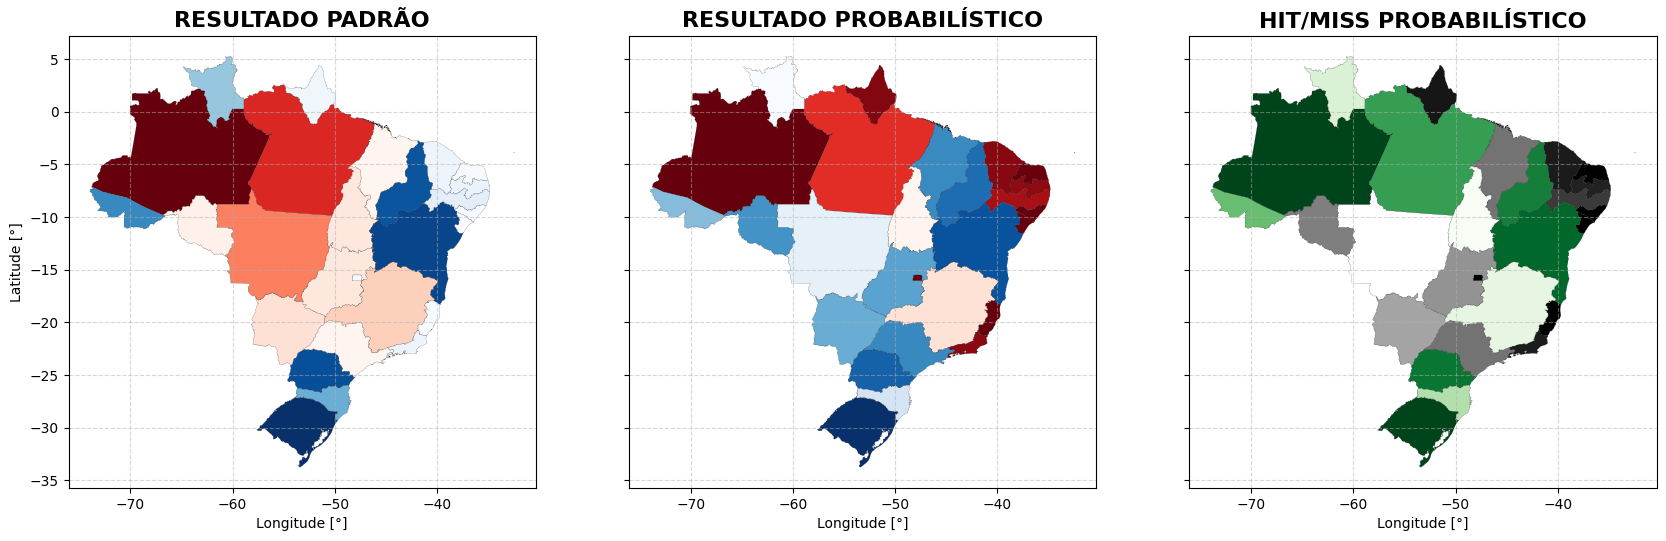

In [395]:
dpi = 100
width = np.round(1366 * 150 / 100)
height = 768*1.75

fig, ax = plt.subplots(1, 3, figsize=(width/dpi, height/dpi), 
                       dpi=dpi, facecolor='w', sharex=True, sharey=True)

orig_map = plot_state_map_original()
prob_map = plot_state_map_prob()

ax[0].set_title('RESULTADO PADRÃO', fontdict=const.STYLE_TITLE)
ax[0].grid(ls='--', alpha=0.5)
ax[0].set_xlabel("Longitude [°]")
ax[0].set_ylabel("Latitude [°]")

orig_map[orig_map['color'] == 'red'].plot(cmap='Reds', ec='k', lw=0.1, 
                                  column='alpha', ax=ax[0])
orig_map[orig_map['color'] == 'blue'].plot(cmap='Blues', ec='k', lw=0.1, 
                                   column='alpha', ax=ax[0])


ax[1].set_title('RESULTADO PROBABILÍSTICO', fontdict=const.STYLE_TITLE)
ax[1].grid(ls='--', alpha=0.5)
ax[1].set_xlabel("Longitude [°]")
# ax[1].set_ylabel("Latitude [°]")

prob_map[prob_map['color'] == 'red'].plot(cmap='Reds', ec='k', lw=0.1, 
                                  column='alpha', ax=ax[1])
prob_map[prob_map['color'] == 'blue'].plot(cmap='Blues', ec='k', lw=0.1, 
                                   column='alpha', ax=ax[1])


ax[2].set_title('HIT/MISS PROBABILÍSTICO', fontdict=const.STYLE_TITLE)
ax[2].grid(ls='--', alpha=0.5)
ax[2].set_xlabel("Longitude [°]")
# ax[2].set_ylabel("Latitude [°]")

prob_map[prob_map['misshit'] == 0].plot(cmap='Greys', ec='k', lw=0.1, 
                                  column='alpha', ax=ax[2])
prob_map[prob_map['misshit'] == 1].plot(cmap='Greens', ec='k', lw=0.1, 
                                   column='alpha', ax=ax[2])

plt.savefig(f"../summary_maps_hourly_uf.png", 
                transparent=False, bbox_inches='tight', pad_inches=0.1)

In [505]:
blue_blue = prob_map.query("color == 'blue' and misshit == 1").count()[0]
blue_red = prob_map.query("color == 'blue' and misshit == 0").count()[0]

red_red = prob_map.query("color == 'red' and misshit == 1").count()[0]
red_blue = prob_map.query("color == 'red' and misshit == 0").count()[0]

sources = [0, 0, 1, 1]
targets = [1+2, 0+2, 0+2, 1+2]
values = [blue_blue, blue_red, red_blue, red_red]
labels = [
    'Inatividade', 'Atividade', 'Miss', 'Hit',
]


colors_node = ['darkblue', 'darkred', '#303030', '#0e532b']
colors_link = ['rgba(43, 101, 227, 0.7)', 'rgba(43, 212, 227, 0.7)', 
               'rgba(231, 120, 110, 0.7)', 'rgba(255, 21, 0, 0.7)']

link = dict(source=sources, target=targets, value=values, color=colors_link)
node = dict(color=colors_node, pad=30, thickness=50)

sankey = go.Sankey(link=link, node=node)
fig = go.Figure(sankey)
fig.update_layout(
    title={
        'text': "<b>ANÁLISE DA INCERTEZA DO CLASSIFICAÇÃO<b>",   
        'y': 0.94,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
            family="Arial",
            size=24,
            color="black",
        )
    },
    font=dict(
        family="Arial",
        size=17,
        color="black",
    )
)

dpi=500
width = 3.5*dpi
height = 1.75*dpi
# fig.write_image("../classes.png", width=1366, height=758, scale=1)
pio.write_image(fig, "../sankey_prob_uf_hourly.svg", width=width, height=height, scale=1)
fig.show()

In [527]:
row.values

array([ 132,   19,    2, ..., 4415, 1942,  180])

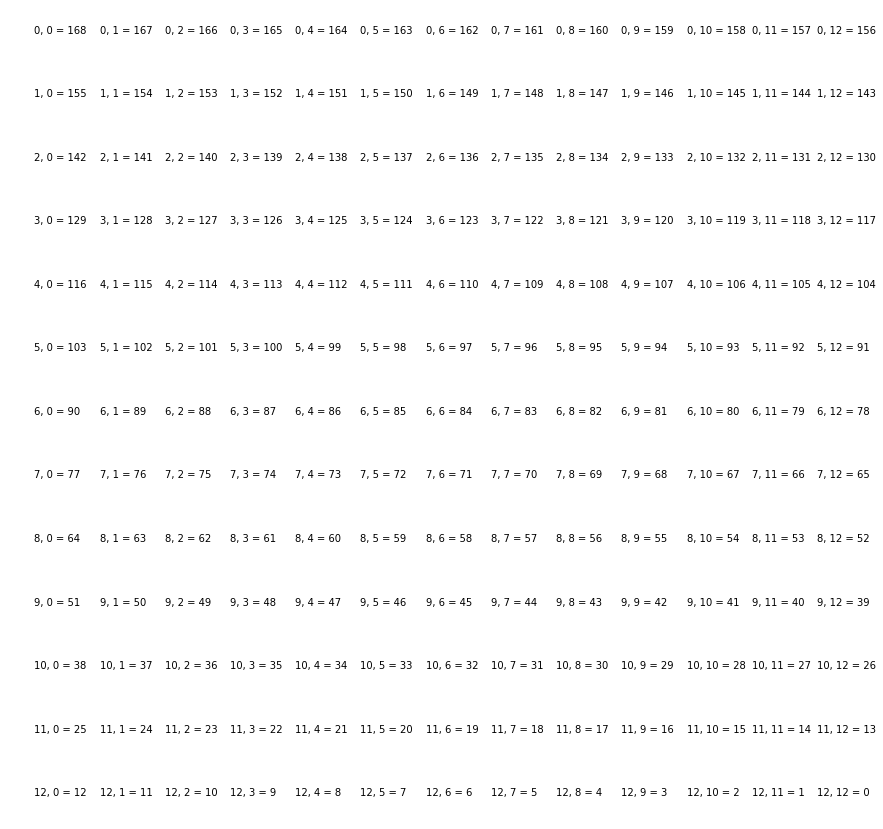

In [548]:
fig, ax = plt.subplots(13, 13, figsize=(15, 15))

for i in  range(13*13):
    r = 12-(i//13)
    c = 12-(i%13)
    ax[r][c].text(0.5, 0.5, f"{r}, {c} = {i}")
    ax[r][c].set_xlim(0, 1)
    ax[r][c].set_ylim(0, 1)
    ax[r][c].axis('off')
    

In [564]:
np.sqrt(5*np.sqrt(data.shape[0]))

5.0971327345413675

AC 1 3 blue
AL 0 7 blue
AM 12 0 red
AP 0 5 blue
BA 4 3 blue
CE 2 6 blue
DF 0 8 blue
ES 0 6 blue
GO 0 0 red
MA 4 0 red
MG 9 3 red
MS 8 8 red
MT 11 12 red
PA 6 12 red
PB 3 8 blue
PE 3 6 blue
PI 3 1 blue
PR 3 11 blue
RJ 2 8 blue
RN 1 7 blue
RO 12 7 red
RR 0 4 blue
RS 0 12 blue
SC 1 10 blue
SE 0 7 blue
SP 6 5 red
TO 7 0 red


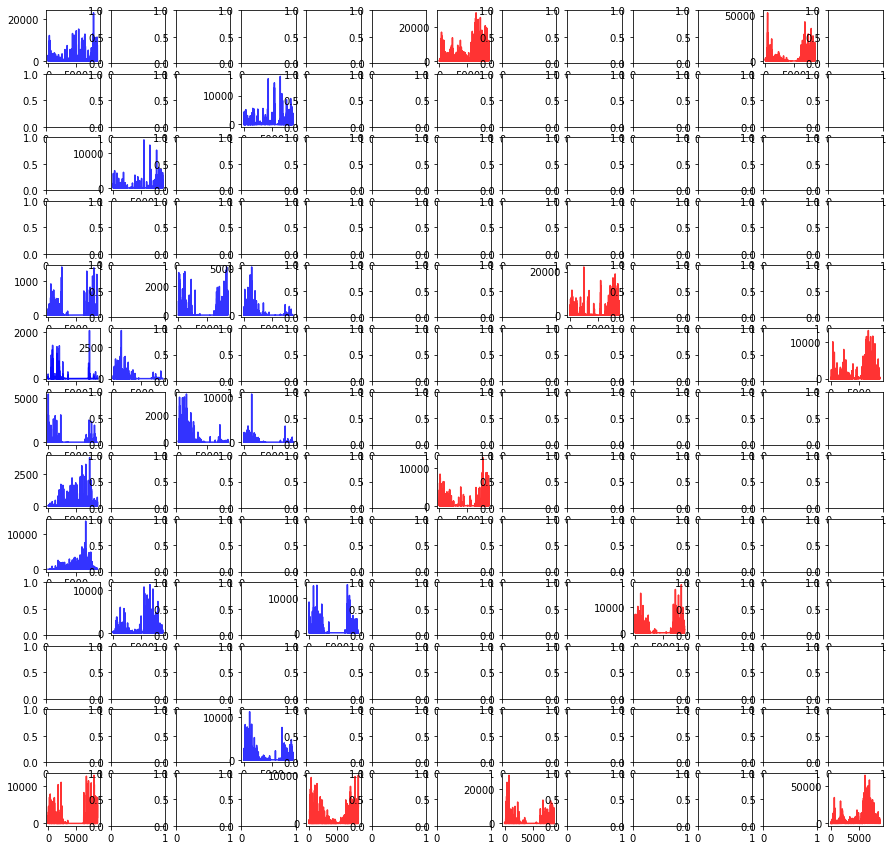

In [557]:
fig, ax = plt.subplots(13, 13, figsize=(15, 15))

for i, (uf, row) in  enumerate(pivot_table.T.iterrows()):
    x, y = SOM.winner(row.values)
    print(uf, x, y, orig_map.loc[uf]['color'])
    ax[12-y][x].plot(row.values, color=orig_map.loc[uf]['color'], alpha=0.8)
    